In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from deepface import DeepFace
from deepface.commons import functions

#!pip install redis
import redis

# Face Recognition Model

In [17]:
model = DeepFace.build_model("Facenet")
model_name = "Facenet"

In [3]:
input_shape = (160, 160)
target_shape = 128

# Target

In [6]:
target_img_path = "target.png"
target_img = functions.preprocess_face(target_img_path, target_size = (160, 160))

24-01-04 01:47:14 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


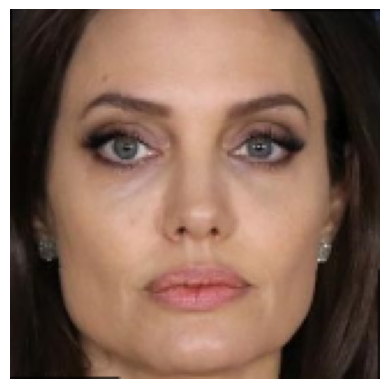

In [8]:
plt.imshow(target_img[:,:,::-1])
plt.axis('off')
plt.show()

In [18]:
target_embedding = DeepFace.represent(img_path=target_img_path, model_name=model_name, enforce_detection=False)[0]["embedding"]

# Getting Redis Server Up

In [13]:
#redis = redis.Redis(host='localhost', port=6379, db=0)
redis = redis.StrictRedis(host='localhost', port=6379, db=0)

In [14]:
for key in redis.scan_iter("embedding:*"):
    redis.delete(key)

for key in redis.scan_iter("photo:*"):
    redis.delete(key)

# Store local db in Redis

In [15]:
local_db = {
    'angelina': 'tests/img2.jpg',
    'jennifer': 'tests/img56.jpg',
    'scarlett': 'tests/img49.jpg',
    'katy': 'tests/img42.jpg',
    'marissa': 'tests/img23.jpg'
}

In [20]:
identities = list(local_db.keys())

for i in tqdm(range(0, len(identities))):
    name = identities[i]
    img_path = local_db[name]
    
    img = functions.preprocess_face(img_path, target_size = (160, 160))
    embedding = DeepFace.represent(img_path=img_path, model_name=model_name)[0]["embedding"]
    
    redis.rpush("embedding:"+name, *embedding)
    redis.set("photo:"+name, img_path)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

24-01-04 01:54:22 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


 20%|████████████████▊                                                                   | 1/5 [00:00<00:02,  1.42it/s]

24-01-04 01:54:22 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


 40%|█████████████████████████████████▌                                                  | 2/5 [00:01<00:01,  1.77it/s]

24-01-04 01:54:23 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:03<00:02,  1.19s/it]

24-01-04 01:54:25 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:03<00:00,  1.11it/s]

24-01-04 01:54:25 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Subsdiary functions

In [21]:
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

# Face verification

In [24]:
def verify_face(key):
    embedding = redis.lrange('embedding:'+key, 0, -1)
    
    #print(embedding)
    #print(np.array(embedding).astype('float'))
    
    distance = findEuclideanDistance(target_embedding, np.array(embedding).astype('float'))
    print("Distance is ",distance)
    
    img_name = redis.get('photo:'+key).decode()
    source_img = functions.preprocess_face(img_name)
    
    #------------------------------------
    
    fig = plt.figure(figsize = (7, 7))
    
    ax1 = fig.add_subplot(1,2,1)
    plt.imshow(target_img[:, :, ::-1])
    plt.axis('off')
    
    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(source_img[:, :, ::-1])
    plt.axis('off')
    
    plt.show()
    
    #------------------------------------
    
    if distance <= 10:
        print("this is "+key)
    else:
        print("this IS NOT "+key)

Distance is  7.460461662555321
24-01-04 01:55:10 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


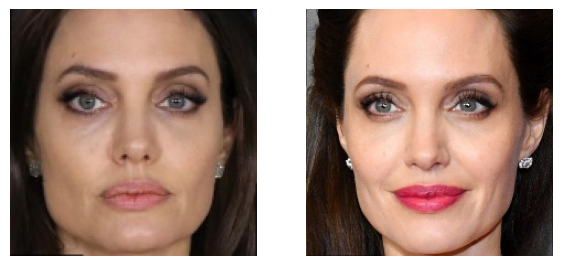

this is angelina


In [25]:
verify_face('angelina')

Distance is  15.630072956668977
24-01-04 01:55:13 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


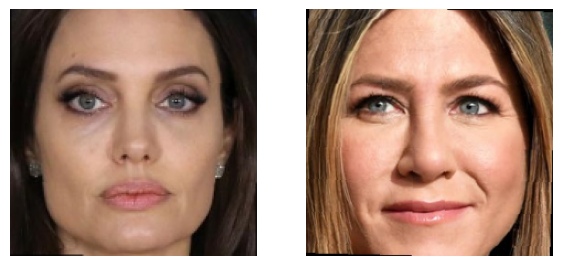

this IS NOT jennifer


In [26]:
verify_face('jennifer')

Distance is  13.53826307450108
24-01-04 01:55:16 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


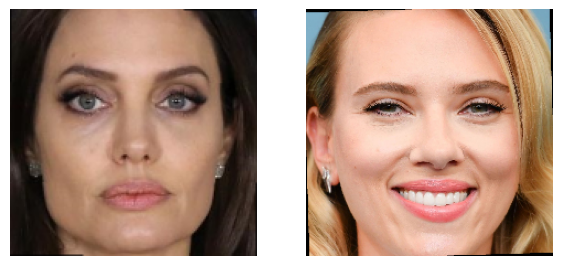

this IS NOT scarlett


In [27]:
verify_face('scarlett')

Distance is  16.15927621160997
24-01-04 01:55:25 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


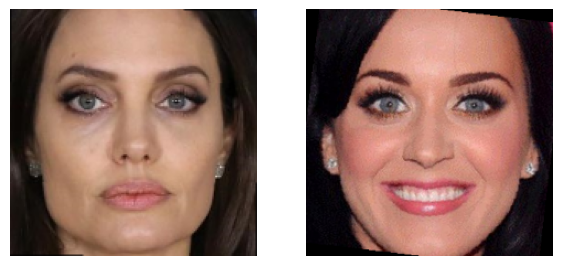

this IS NOT katy


In [28]:
verify_face('katy')

Distance is  16.27390359850951
24-01-04 01:55:27 - ⚠️ Function preprocess_face is deprecated. Use extract_faces instead.


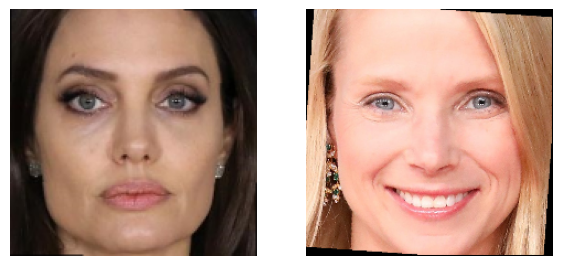

this IS NOT marissa


In [29]:
verify_face('marissa')

# Server side face verification

In [30]:
verify_script = '''
local source = KEYS[1]
local source_embedding = redis.call("lrange", "embedding:"..source, 0, -1)

local distance = 0
for i = 1, #source_embedding do
    distance = distance + (source_embedding[i] - KEYS[1+i])^2
end

distance = math.sqrt(distance)

return {"euclidean_distance", tostring(distance)}
'''

In [31]:
command = redis.register_script(verify_script)

In [32]:
float(command(keys = ["angelina", *target_embedding])[1].decode()) <= 10

True

In [33]:
float(command(keys = ["jennifer", *target_embedding])[1].decode()) <= 10

False

In [34]:
float(command(keys = ["katy", *target_embedding])[1].decode()) <= 10

False

In [35]:
float(command(keys = ["scarlett", *target_embedding])[1].decode()) <= 10

False

In [36]:
float(command(keys = ["marissa", *target_embedding])[1].decode()) <= 10

False

# Server side face recognition

In [37]:
find_script = '''
local db = redis.call("SCAN", 0, "MATCH", "embedding:*")[2]

local identities = {}
local distances = {}

local idx = 1
for i=1, #db do
    local source_key = db[i]
    local source_embedding = redis.call("lrange", source_key, 0, -1)
    
    local distance = 0
    for j=1, #source_embedding do
        distance = distance + (source_embedding[j] - KEYS[j])^2
    end
    
    distance = math.sqrt(distance)
    
    if distance <= 10 then
        distances[idx] = tostring(distance)
        identities[idx] = source_key
        idx = idx + 1
    end
    
end

return {identities, distances}
'''

In [38]:
command = redis.register_script(find_script)

In [39]:
results = command(keys = [*target_embedding])

In [40]:
results

[[b'embedding:angelina'], [b'7.4604616625553']]